- https://www.datacamp.com/tutorial/pyspark-tutorial-getting-started-with-pyspark
- https://archive.ics.uci.edu/dataset/352/online+retail

In [1]:
import os
import sys
import pandas as pd
import numpy as np

# Create Spark context
from pyspark import SparkContext, SparkConf
from pyspark.sql import functions as F
from pyspark.sql.types import *
conf = SparkConf().setAppName('dj').setMaster('local[*]')\
    .set("spark.memory.offHeap.enabled","true") \
    .set("spark.memory.offHeap.size","8g")
sc = SparkContext(conf=conf)

# Create Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('dj').getOrCreate()
spark

In [2]:
# !pip install openpyxl

In [45]:
# Step 2: Creating the DataFrame
df = spark.read.csv('ecommerce.csv',header=True,escape="\"")
df = df.withColumn('CustomerID',df['CustomerID'].cast(IntegerType()))\
    .withColumn('Quantity',df['Quantity'].cast(IntegerType()))\
    .withColumn('UnitPrice',df['UnitPrice'].cast(DoubleType()))


df.show(5,0)

+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |2010-12-01 08:26:00|2.55     |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |2010-12-01 08:26:00|3.39     |17850     |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |2010-12-01 08:26:00|2.75     |17850     |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |2010-12-01 08:26:00|3.39     |17850     |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |2010-12-01 08:26:00|3.39     |17850     |United Kingdom|
+---------+-----

The dataframe consists of 8 variables:

- InvoiceNo: The unique identifier of each customer invoice. 
- StockCode: The unique identifier of each item in stock.
- Description: The item purchased by the customer.
- Quantity: The number of each item purchased by a customer in a single invoice.
- InvoiceDate: The purchase date.
- UnitPrice: Price of one unit of each item.
- CustomerID: Unique identifier assigned to each user.
- Country: The country from where the purchase was made

In [46]:
# Explore the DataFrame
df.count()  # Answer: 2,500

541909

In [47]:
df.select('CustomerID').distinct().count() # Answer: 95

4373

In [48]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

df.groupBy('Country')\
    .agg(countDistinct('CustomerID').alias('country_count'))\
    .show(5,0)

+---------+-------------+
|Country  |country_count|
+---------+-------------+
|Sweden   |8            |
|Singapore|1            |
|Germany  |95           |
|RSA      |1            |
|France   |87           |
+---------+-------------+
only showing top 5 rows



In [49]:
df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).orderBy(desc('country_count')).show(5,0)

+--------------+-------------+
|Country       |country_count|
+--------------+-------------+
|United Kingdom|3950         |
|Germany       |95           |
|France        |87           |
|Spain         |31           |
|Belgium       |25           |
+--------------+-------------+
only showing top 5 rows



In [50]:
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [51]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
# df = df.withColumn('date',to_timestamp("InvoiceDate", 'yy/MM/dd HH:mm'))
df = df.withColumn('date',to_timestamp("InvoiceDate", 'yyyy-MM-dd HH:mm'))
df.select(max("date")).show(2,0)

+-------------------+
|max(date)          |
+-------------------+
|2011-12-09 12:50:00|
+-------------------+



In [52]:
df.select(min("date")).show(3,0)

+-------------------+
|min(date)          |
+-------------------+
|2010-12-01 08:26:00|
+-------------------+



Data Pre-processing

In [53]:
# recency, frequency, and monetary value (RFM).
# i) Assign a recency score to each customer
df = df.withColumn("from_date", lit("10/12/01 08:26"))
df = df.withColumn('from_date',to_timestamp("from_date", 'yy/MM/dd HH:mm'))
df2=df.withColumn('from_date',to_timestamp(col('from_date')))\
    .withColumn('recency',col("date").cast("long") - col('from_date').cast("long"))
# df2 = df2.dropDuplicates(subset=['date'])
df2.show(3,0)


+---------+---------+----------------------------------+--------+-------------------+---------+----------+--------------+-------------------+-------------------+-------+
|InvoiceNo|StockCode|Description                       |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |date               |from_date          |recency|
+---------+---------+----------------------------------+--------+-------------------+---------+----------+--------------+-------------------+-------------------+-------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER|6       |2010-12-01 08:26:00|2.55     |17850     |United Kingdom|2010-12-01 08:26:00|2010-12-01 08:26:00|0      |
|536365   |71053    |WHITE METAL LANTERN               |6       |2010-12-01 08:26:00|3.39     |17850     |United Kingdom|2010-12-01 08:26:00|2010-12-01 08:26:00|0      |
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER    |8       |2010-12-01 08:26:00|2.75     |17850     |United Kingdom|2010-12-01 08:26:00|2010-12-0

In [54]:
# ii) Select the most recent purchase
df2 = df2.join(df2.groupBy('CustomerID')\
    .agg(max('recency').alias('recency')),on='recency',how='leftsemi')
df2.show(5,0)

+-------+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+-------------------+-------------------+
|recency|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |date               |from_date          |
+-------+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+-------------------+-------------------+
|5220   |536384   |82484    |WOOD BLACK BOARD ANT WHITE FINISH  |3       |2010-12-01 09:53:00|6.45     |18074     |United Kingdom|2010-12-01 09:53:00|2010-12-01 08:26:00|
|5220   |536384   |84755    |COLOUR GLASS T-LIGHT HOLDER HANGING|48      |2010-12-01 09:53:00|0.65     |18074     |United Kingdom|2010-12-01 09:53:00|2010-12-01 08:26:00|
|5220   |536384   |22464    |HANGING METAL HEART LANTERN        |12      |2010-12-01 09:53:00|1.65     |18074     |United Kingdom|2010-12-01 09:5

In [55]:
df2.printSchema()

root
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)



Frequency 

In [56]:
df_freq = df2.groupBy('CustomerID').agg(count('InvoiceDate').alias('frequency')).orderBy(desc('frequency'))
df_freq.show(5,0)

+----------+---------+
|CustomerID|frequency|
+----------+---------+
|NULL      |2625     |
|14096     |544      |
|14911     |417      |
|17841     |324      |
|14730     |314      |
+----------+---------+
only showing top 5 rows



In [57]:
df3 = df2.join(df_freq,on='CustomerID',how='inner')

df3.printSchema()

root
 |-- CustomerID: integer (nullable = true)
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- frequency: long (nullable = false)



Monetary value

In [71]:


df3.select(max('Quantity'),min('Quantity')).show(2,0)
df3.select(max('UnitPrice'),min('UnitPrice')).show(2,0)

+-------------------+-------------------+
|max(monetary_value)|min(monetary_value)|
+-------------------+-------------------+
|21535.9            |-168469.6          |
+-------------------+-------------------+

+-------------+-------------+
|max(Quantity)|min(Quantity)|
+-------------+-------------+
|12540        |-80995       |
+-------------+-------------+

+--------------+--------------+
|max(UnitPrice)|min(UnitPrice)|
+--------------+--------------+
|4287.63       |0.0           |
+--------------+--------------+



In [58]:
# i) Find the total amount spent in each purchase:
m_val = df3.withColumn('TotalAmount',col("Quantity") * col("UnitPrice"))
m_val.show(5,0)
m_val.select(max('monetary_value'),min('monetary_value')).show(2,0)
# ii) Find the total amount spent by each customer:
m_val = m_val.groupBy('CustomerID').agg(sum('TotalAmount').alias('monetary_value'))
m_val = m_val.filter(m_val.monetary_value > 0)

# Merge this dataframe with the all the other variables:
finaldf = m_val.join(df3,on='CustomerID',how='inner')
finaldf = finaldf.select(['recency','frequency','monetary_value','CustomerID']).distinct()
finaldf.show(5,0)


+----------+-------+---------+---------+-----------------------------------+--------+-------------------+---------+--------------+-------------------+-------------------+---------+------------------+
|CustomerID|recency|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate        |UnitPrice|Country       |date               |from_date          |frequency|TotalAmount       |
+----------+-------+---------+---------+-----------------------------------+--------+-------------------+---------+--------------+-------------------+-------------------+---------+------------------+
|18074     |5220   |536384   |82484    |WOOD BLACK BOARD ANT WHITE FINISH  |3       |2010-12-01 09:53:00|6.45     |United Kingdom|2010-12-01 09:53:00|2010-12-01 08:26:00|13       |19.35             |
|18074     |5220   |536384   |84755    |COLOUR GLASS T-LIGHT HOLDER HANGING|48      |2010-12-01 09:53:00|0.65     |United Kingdom|2010-12-01 09:53:00|2010-12-01 08:26:00|13       |31.200000000000003|


In [59]:
finaldf.count()

4332

Standardization

In [60]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

assemble=VectorAssembler(inputCols=[
    'recency','frequency','monetary_value'
], outputCol='features')

assembled_data=assemble.transform(finaldf)

scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.select('standardized').show(2,0)

+------------------------------------------------------------+
|standardized                                                |
+------------------------------------------------------------+
|[0.08344158397307705,0.8222697882809382,0.24718209385169487]|
|[0.09348560777683913,0.07475179893463074,0.2054823149176329]|
+------------------------------------------------------------+
only showing top 2 rows



In [61]:
# Building the Machine Learning Model
# - Finding the number of clusters to use
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

cost = np.zeros(10)

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized',metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost

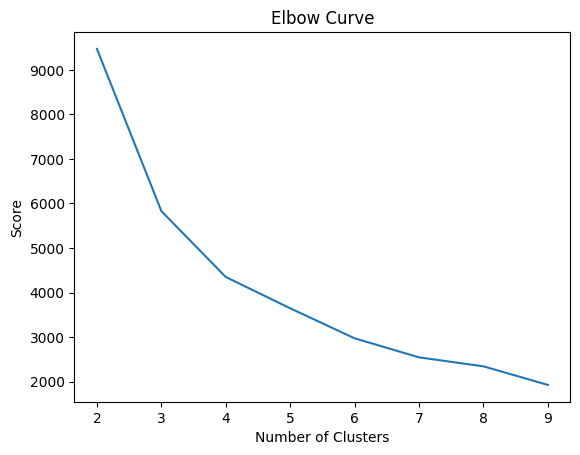

In [62]:
import pandas as pd
import pylab as pl
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [63]:
# ii) Building the K-Means Clustering Model
KMeans_algo=KMeans(featuresCol='standardized', k=4)
KMeans_fit=KMeans_algo.fit(data_scale_output)
# iii) Making Predictions
preds=KMeans_fit.transform(data_scale_output)
preds.show(5,0)

+-------+---------+------------------+----------+----------------------------------+---------------------------------------------------------------+----------+
|recency|frequency|monetary_value    |CustomerID|features                          |standardized                                                   |prediction|
+-------+---------+------------------+----------+----------------------------------+---------------------------------------------------------------+----------+
|716280 |33       |208.95            |17950     |[716280.0,33.0,208.95]            |[0.08344158397307705,0.8222697882809382,0.24718209385169487]   |2         |
|802500 |3        |173.7             |16565     |[802500.0,3.0,173.7]              |[0.09348560777683913,0.07475179893463074,0.2054823149176329]   |2         |
|97020  |1        |106.2             |15070     |[97020.0,1.0,106.2]               |[0.011302147871039168,0.024917266311543583,0.12563167440559941]|2         |
|105180 |13       |248.10000000000002|16

In [64]:
# !pip install seaborn

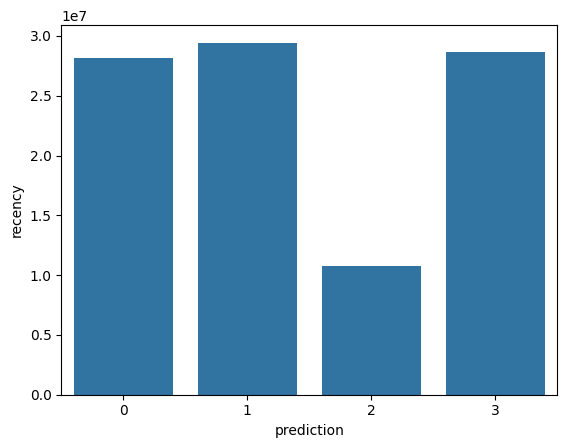

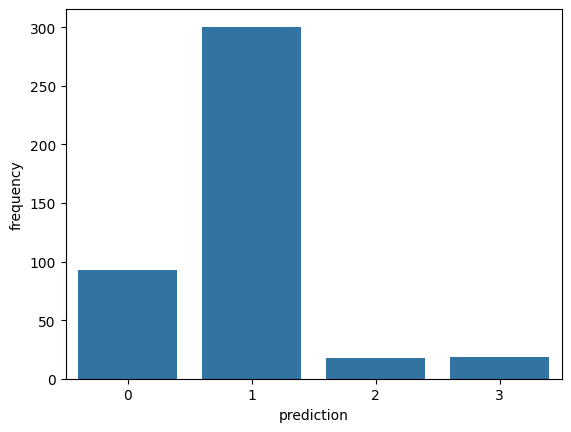

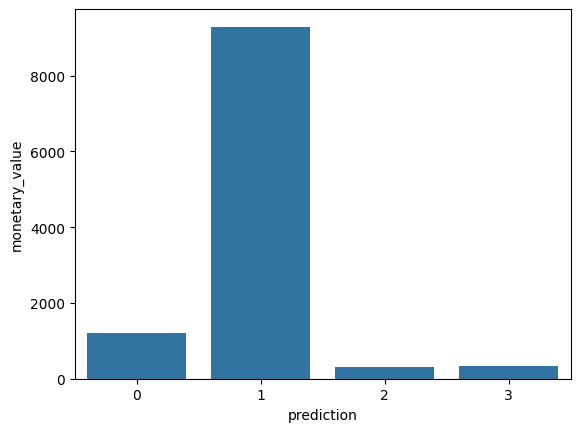

In [65]:
# Step 6: Cluster Analysis
import matplotlib.pyplot as plt
import seaborn as sns

df_viz = preds.select('recency','frequency','monetary_value','prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

list1 = ['recency','frequency','monetary_value']

for i in list1:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()